This notebook aims to understand `rl_learner/utils/plotting.py`.

# Running dummy experiments

In [2]:
import sys
sys.path.append('../')  # For importing `rl_learners`

import os
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rl_learner.utils.logger import EpochLogger

In [3]:
output_dir = './results/plotting'
exp_name = 'random'
n_episodes = 100
run_ids = [0, 1, 2, 3]

env = gym.make('CartPole-v1')

for run_id in run_ids:
    logger = EpochLogger(output_dir, exp_name, run_id=run_id)
    for e in range(n_episodes):
        s, done, epi_r = env.reset(), False, 0
        while not done:
            a = env.action_space.sample()
            s_prime, r, done, info = env.step(a)
            epi_r += r
            
        logger.log(
            Epoch=e,
            AverageEpRet=epi_r
        )
    logger.dump()

# Collecting experiments

In [4]:
def get_datasets(logdir):
    """
    Recursively look through logdir for output files produced by EpochLogger. 

    Assumes that any file "progress.txt" is a valid hit.

    Refereces:
        https://github.com/openai/spinningup/blob/master/spinup/utils/plot.py#L61
    """
    datasets = []
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            exp_dir, run_id = os.path.split(root)
            _, exp_name = os.path.split(exp_dir)
            exp_data = pd.read_table(os.path.join(root, 'progress.txt'))

            # Add columns indicating experiments
            exp_data.insert(len(exp_data.columns), 'Exp', exp_name)
            exp_data.insert(len(exp_data.columns), 'ID', run_id)
            exp_data.insert(len(exp_data.columns), 'Exp-ID', exp_name + '-' + run_id)

            datasets.append(exp_data)

    return datasets

In [5]:
datasets = get_datasets(logdir='./results/plotting')
datasets

[    Epoch  AverageEpRet     Exp ID    Exp-ID
 0       0          16.0  random  0  random-0
 1       1          11.0  random  0  random-0
 2       2          10.0  random  0  random-0
 3       3          10.0  random  0  random-0
 4       4          30.0  random  0  random-0
 ..    ...           ...     ... ..       ...
 95     95          44.0  random  0  random-0
 96     96          15.0  random  0  random-0
 97     97          15.0  random  0  random-0
 98     98          33.0  random  0  random-0
 99     99          15.0  random  0  random-0
 
 [100 rows x 5 columns],
     Epoch  AverageEpRet     Exp ID    Exp-ID
 0       0          22.0  random  1  random-1
 1       1          16.0  random  1  random-1
 2       2          29.0  random  1  random-1
 3       3          12.0  random  1  random-1
 4       4          12.0  random  1  random-1
 ..    ...           ...     ... ..       ...
 95     95          22.0  random  1  random-1
 96     96          16.0  random  1  random-1
 97    

# Plotting

In [6]:
def plot_data(data, target="AverageEpRet", smooth=1, hue='Exp', **kwargs):
    if smooth > 1:
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[target])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x, y, 'same') / np.convolve(z, y, 'same')
            datum[target] = smoothed_x

    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)

    # Plotting    
    sns.set(style='darkgrid', font_scale=1.5)
    sns.lineplot(data=data, x='Epoch', y=target, hue=hue, **kwargs)
    plt.legend(loc='best').set_draggable(True)

    xscale = np.max(np.asarray(data['Epoch'])) > 5e3
    if xscale:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 1))
    plt.tight_layout(pad=0.5)

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


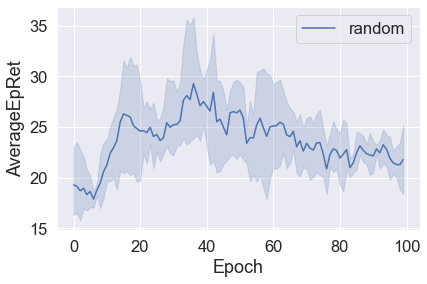

In [8]:
plt.figure()
plot_data(datasets, target='AverageEpRet', hue='Exp', smooth=10)
plt.show()